____
## Introduction

In this project I examined a dataset of 10 thousand buildings from Manhattan, New York which participated in the 2022 ENERGY STAR evaluation. The dataset was queried by myself from the NYC database at https://data.cityofnewyork.us/Environment/NYC-Building-Energy-and-Water-Data-Disclosure-for-/5zyy-y8am/about_data.

My goal was to uncover relationships between the date that a building was constructed, the primary usage of the building, and the energy efficiency. To achieve this goal I performed statistical analysis using correlation coefficients and found a significant $(P = 2.76e^{-25})$ negative correlation between the age of buildings built between 1900 and 2005, and a significant $(P = 3.39e^{-10})$ positive correlation between the age of buildings built between 2005 and 2020. These findings indicate that there was a downward trend in the quality of Manhattan building designs and/or materials with respect to energy efficiency beginning around 1950 and reaching an all-time low during the early 2000s. The year 2005 is an inflection point and after 2005 there is a sharp increase in building efficiency trending upward to its current peak in the 2020s. This change may be a result of the 2005 Energy Policy Act which gave commercial buildings a financial incentive to invest in energy efficiency.  

The ENERGY STAR score is a percentile that is assigned by the EPA and is a benchmark for assessing the performance of commercial buildings. It compares a building's energy efficiency to a national database of similar buildings throughout the course of a year. The energy consumption is normalized for building activity. More information can be found at: https://portfoliomanager.energystar.gov/pdf/reference/ENERGY%20STAR%20Score.pdf.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
# read in data
df = pd.read_csv('/kaggle/input/manhattan-nyc-building-energy-data-2022/NYC_Building_Energy_and_Water_Data_Disclosure_for_Local_Law_84__2023-Present__20240306.csv')

# display initial dataframe
df

,Report Year,"NYC Borough, Block and Lot (BBL)",City,Primary Property Type - Portfolio Manager-Calculated,Year Built,ENERGY STAR Score,Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Total (Location-Based) GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Address 1
0,2022,1- 02090-0024,NEW YORK,Multifamily Housing,1909,34,3591399,3712495.1,265,31794.0,615 W 143RD STREET
1,2022,1-00002-0002,New York,Hotel,1900,Not Available,36220963.6,37279986.5,2243.4,193000.0,10 South Street
2,2022,1-00004-7501,New York,Office,1970,64,223447780.6,223455790.5,16458.5,2542563.0,1 Water Street
3,2022,1-00007-7501,New York,Multifamily Housing,1880,14,4211270.2,4293772.8,287.5,44907.0,66 Pearl Street
4,2022,1-00008-0044,NEW YORK,Data Center,1917,Not Available,31945520.8,32148605.3,2577.8,217034.0,104 BROAD ST
...,...,...,...,...,...,...,...,...,...,...,...
10969,2022,1022500050,Manhattan,Multifamily Housing,1930,86,4391011.4,4497754.2,260,68592.0,583 West 215th Street
10970,2022,1022500072,New York,Multifamily Housing,1926,100,856601.9,835425,69.2,52800.0,270 Seaman Ave
10971,2022,1022500075,New York,Multifamily Housing,1930,87,2604877.3,2666504.1,154.2,40105.0,260 Seaman Ave
10972,2022,1027620103,BRONX,Multifamily Housing,1962,100,1603.7,1603.6,0.1,35875.0,855 BRYANT AVE 1B


______
## Preprocessing and cleaning

In [3]:
# drop all rows from the dataframe in which the city is not 'New York' or 'Manhattan' and display value counts
df = df[(df['City'] == 'New York') | (df['City'] == 'Manhattan')]
df['City'].value_counts()

City
New York     9410
Manhattan     804
Name: count, dtype: int64

In [4]:
# drop all rows which do not contain valid entries
df = df[df['ENERGY STAR Score'] != 'Not Available']
df = df[df['Weather Normalized Site Energy Use (kBtu)'] != 'Not Available']
df = df[df['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] != 'Not Available']

In [5]:
# display unique value counts for Primary Property Type
df['Primary Property Type - Portfolio Manager-Calculated'].value_counts()

Primary Property Type - Portfolio Manager-Calculated
Multifamily Housing                      5403
Office                                   1295
Hotel                                     359
K-12 School                               289
Residence Hall/Dormitory                  116
Worship Facility                           57
Retail Store                               45
Hospital (General Medical & Surgical)      26
Medical Office                             24
Financial Office                           23
Senior Living Community                    20
Non-Refrigerated Warehouse                 16
Courthouse                                  7
Mixed Use Property                          6
Supermarket/Grocery Store                   5
Bank Branch                                 4
Distribution Center                         3
Wastewater Treatment Plant                  2
Data Center                                 1
Single-Family Home                          1
Name: count, dtype: int64

The dataset consists of buildings categorized by the primary property type. For the sake of sample size I eliminated building types which occur less than 10 times.

In [6]:
# eliminate building categories which occur less than 10 times and display the new categories
df = df[df['Primary Property Type - Portfolio Manager-Calculated'].map(df['Primary Property Type - Portfolio Manager-Calculated'].value_counts()) >= 23]
df['Primary Property Type - Portfolio Manager-Calculated'].value_counts()

Primary Property Type - Portfolio Manager-Calculated
Multifamily Housing                      5403
Office                                   1295
Hotel                                     359
K-12 School                               289
Residence Hall/Dormitory                  116
Worship Facility                           57
Retail Store                               45
Hospital (General Medical & Surgical)      26
Medical Office                             24
Financial Office                           23
Name: count, dtype: int64

In [7]:
# change columns into more appropriate datatypes
df['ENERGY STAR Score'] = df['ENERGY STAR Score'].astype(int)
df['Site Energy Use (kBtu)'] = df['Site Energy Use (kBtu)'].astype(float)
df['Weather Normalized Site Energy Use (kBtu)'] = df['Weather Normalized Site Energy Use (kBtu)'].astype(float)
df['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] = df['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].astype(float)
df['Property GFA - Self-Reported (ft²)'] = df['Property GFA - Self-Reported (ft²)'].astype(float)

I found some inconsistencies in the 'year built' column, for example the earliest year was listed at 1600 but other data sources show that building as having been built in 1913. For this reason I dropped the rows which contained values prior to 1900.

In [8]:
# drop all rows which contain year built values earlier than 1900
df = df[df['Year Built'] >= 1900]

_________
## Statistical Analysis

In [9]:
# compute the average energy score for all categories
df['ENERGY STAR Score'].mean()

62.487104493485774

To investigate the relationship between build year and energy star score, the first step I took was to create a plot of the average energy star ratings for each building constructed in a given build year.

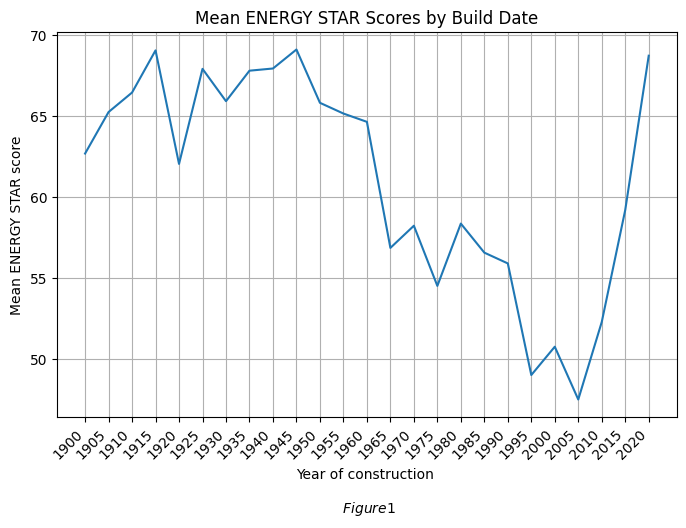

In [10]:
# create a new column which categorizes the build year by decade
df['Decade Built'] = ((df['Year Built'] // 5) * 5).astype(str) 

# plot the average ENERGY STAR scores of buildings based on the build year
plt.figure(figsize=(8,5))
plt.plot(df.groupby(['Decade Built'])['ENERGY STAR Score'].mean())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Year of construction \n \n $\it{Figure  1}$')
plt.ylabel('Mean ENERGY STAR score')
plt.title('Mean ENERGY STAR Scores by Build Date')
plt.grid()


This plot shows a clear downward trend from 1945, an inflection point at 2005, and a sharp upward trend from 2005 to present day. 

In [11]:
# average year built
avg_build = pd.DataFrame(df.groupby(['Primary Property Type - Portfolio Manager-Calculated'])['Year Built'].mean().round(0).astype(int))
avg_build.rename(columns={'Year Built': 'Average year built'}, inplace=True)
avg_build

,Average year built
Primary Property Type - Portfolio Manager-Calculated,
Financial Office,1972
Hospital (General Medical & Surgical),1961
Hotel,1969
K-12 School,1955
Medical Office,1953
Multifamily Housing,1946
Office,1935
Residence Hall/Dormitory,1943
Retail Store,1950


In [12]:
# compute the pearson correlation coefficients between energy star score and year built for each building category
correlations = pd.DataFrame(df.groupby(['Primary Property Type - Portfolio Manager-Calculated'])['ENERGY STAR Score'].corr(df['Year Built'], method='pearson'))
correlations.rename(columns={'ENERGY STAR Score': 'Correlation'}, inplace=True)
correlations

,Correlation
Primary Property Type - Portfolio Manager-Calculated,
Financial Office,-0.289401
Hospital (General Medical & Surgical),-0.351809
Hotel,-0.051787
K-12 School,-0.122803
Medical Office,-0.474621
Multifamily Housing,-0.126494
Office,-0.135796
Residence Hall/Dormitory,-0.338334
Retail Store,-0.082562


ENERGY STAR states that the year built is not factored into the score. With this information, the correlation coefficients indicate that more recent buildings tend to be less energy efficient. Comparing this to the plot of mean ENERGY STAR scores by build decade in Figure 1, it seems that the downward trend in efficiency reaching its low point in the 2000s is responsible for this negative correlation.  

source: https://www.energystar.gov/sites/default/files/tools/LicensedProfGuide_Feb2015_508%20compliant.pdf

In the next step, I determine whether these results are statistically significant by repeating the calculation with ```scipy.stats``` and returning the P-value for each correlation coefficient.

In [13]:
print(f"{'Category':<50} {'Correlation Coefficient':<35} {'P-value':<25} {'Significance':<20}")
print("-" * 100) 

for category in df['Primary Property Type - Portfolio Manager-Calculated'].unique():

    significance = ''

    corr, p_val = scipy.stats.pearsonr(df[df['Primary Property Type - Portfolio Manager-Calculated'] == category]['ENERGY STAR Score'], \
                                       df[df['Primary Property Type - Portfolio Manager-Calculated'] == category]['Year Built'])
    
    if p_val <= 0.05:
        significance = 'Significant'
    else:
        significance = 'Insignificant'

    print(f"{category:<50} {corr:.5f}{'':<28} {p_val:.5e}{'':<15} {significance}")

Category                                           Correlation Coefficient             P-value                   Significance        
----------------------------------------------------------------------------------------------------
Office                                             -0.13580                             1.47362e-06                Significant
Multifamily Housing                                -0.12649                             1.43332e-20                Significant
Hotel                                              -0.05179                             3.34029e-01                Insignificant
K-12 School                                        -0.12280                             3.93158e-02                Significant
Financial Office                                   -0.28940                             2.03218e-01                Insignificant
Hospital (General Medical & Surgical)              -0.35181                             9.18178e-02                Insignifica

The results show statistical significance for the following building types: Office, Multifamily Housing, K-12 School, Residence Hall, Worship Facility, and Medical Office.  
The building categories which have the strongest significant correlation are: Medical Office, Residence Hall, and Worship Facility. It's worth noting that Office and Multifamily Housing make up the majority of entries in the dataset by far, and these are significantly correlated with age.  

Next, I computed the significance of the correlations for time periods before and after the 2005 inflection point.

In [14]:
# compute the overall correlation prior to year 2005
print(f" \033[1mCorrelation for build dates prior to 2005\033[0m \n")
print(f" {'Correlation Coefficient':<35} {'P-value':<25} {'Significance':<20}")
print("-" * 100) 

cor, p_val = scipy.stats.pearsonr(df[df['Year Built'] <= 2005]['ENERGY STAR Score'], df[df['Year Built'] <= 2005]['Year Built'])
if p_val <= 0.05:
    significance = 'Significant'
else:
    significance = 'Insignificant'
print(f"{'':<2}{cor:.5f}{'':<25} {p_val:.5e}{'':<15} {significance}")

 Correlation for build dates prior to 2005 

 Correlation Coefficient             P-value                   Significance        
----------------------------------------------------------------------------------------------------
  -0.12600                          2.75756e-25                Significant


In [15]:
# compute the overall correlation after year 2005
print(f" \033[1mCorrelation for build dates after 2005\033[0m \n")
print(f" {'Correlation Coefficient':<35} {'P-value':<25} {'Significance':<20}")
print("-" * 100) 

cor, p_val = scipy.stats.pearsonr(df[df['Year Built'] >= 2005]['ENERGY STAR Score'], df[df['Year Built'] >= 2005]['Year Built'])
if p_val <= 0.05:
    significance = 'Significant'
else:
    significance = 'Insignificant'
print(f"{'':<2}{cor:.5f}{'':<25} {p_val:.5e}{'':<16} {significance}")

 Correlation for build dates after 2005 

 Correlation Coefficient             P-value                   Significance        
----------------------------------------------------------------------------------------------------
  0.21573                          3.38757e-10                 Significant


These results indicate a statistically significant correlation both before and after 2005, with a negative correlation prior to 2005 and a positive correlation from 2005 to present.

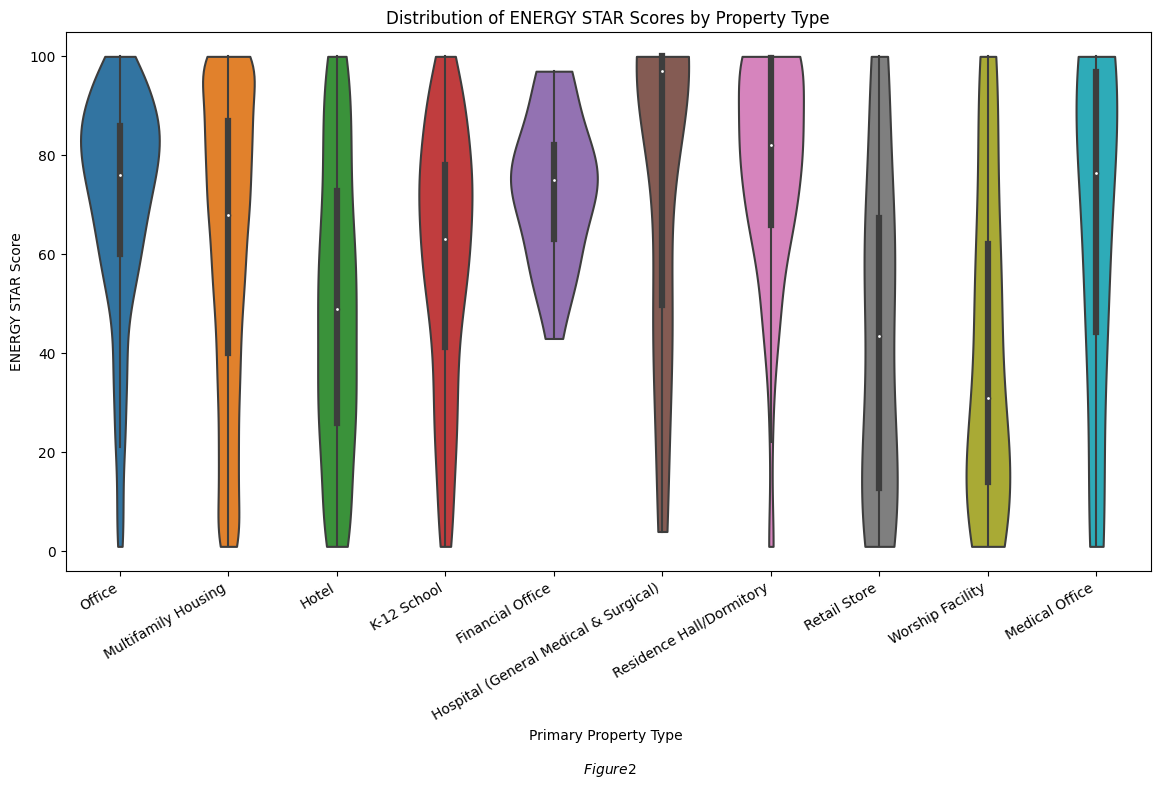

In [16]:
# create a violin plot to visualize the mean energy star scores by category
plt.figure(figsize=(14,7))
sns.violinplot(x='Primary Property Type - Portfolio Manager-Calculated', y='ENERGY STAR Score', data=df, cut=0);
plt.xticks(rotation=30, ha='right');
plt.xlabel('Primary Property Type \n \n $\it{Figure 2}$' );
plt.title('Distribution of ENERGY STAR Scores by Property Type');

This figure shows that the building type which has the highest average ENERGY STAR score are hospitals, and the lowest being worship facilities. In Manhattan, worship facilities had the earliest average year built of 1934. Many of these buildings are historical sites.  

Because the ENERGY STAR score is a national percentile and this dataset consists of primarily Office and Multifamily Housing, this indicates that the majority of participating Manhattan buildings are above the national average in terms of energy efficiency.

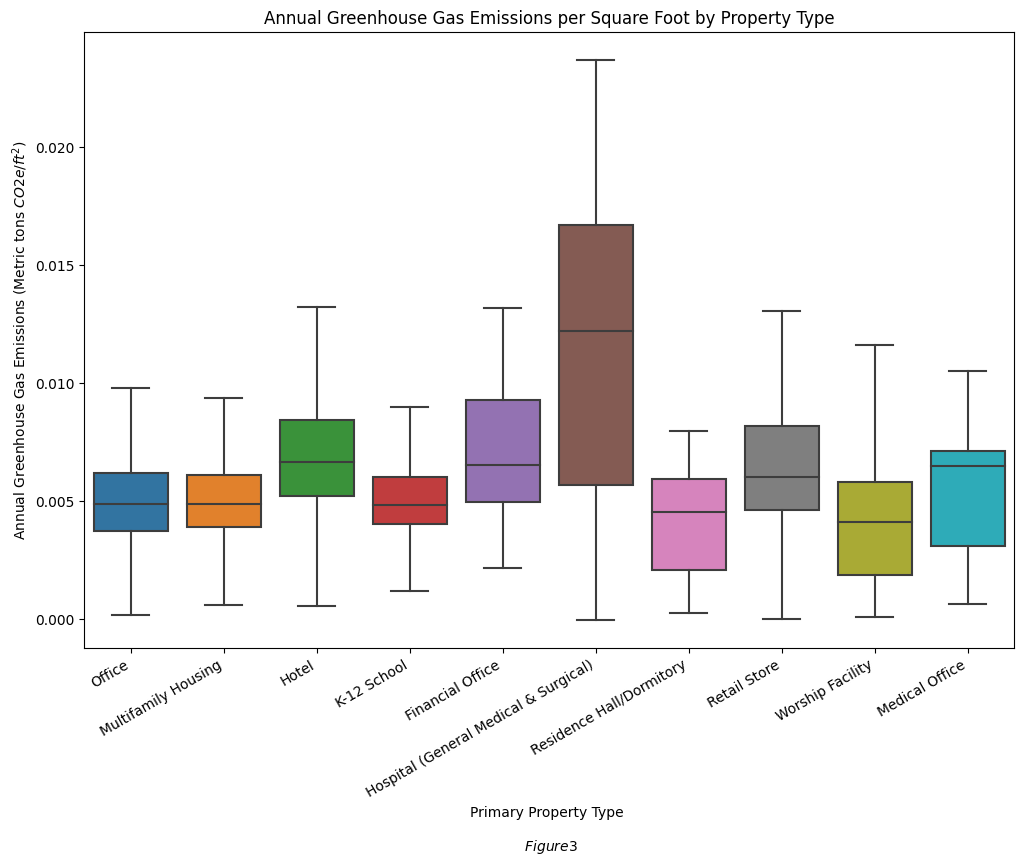

In [17]:
# create new column with annual GHG emissions per square foot of floor space
df['normalized_emissions'] = df['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']/df['Property GFA - Self-Reported (ft²)']

# creat boxplot of normalized annual carbon emissions per squuare foot
plt.figure(figsize=(12,8))
sns.boxplot(x='Primary Property Type - Portfolio Manager-Calculated', y='normalized_emissions', data=df, showfliers=False);
plt.xticks(rotation=30, ha='right');
plt.xlabel('Primary Property Type \n \n $\it{Figure 3}$');
plt.ylabel('Annual Greenhouse Gas Emissions (Metric tons $CO2e/ft^2$)')
plt.title('Annual Greenhouse Gas Emissions per Square Foot by Property Type');

This figure shows that Hospitals have the largest GHG emissions by a significant amount, however, Hospitals are also the top most efficient category of buildings.